# Задание по программированию: Размещение баннеров

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.



In [1]:
import os, urllib
from io import BytesIO
from zipfile import ZipFile
from pathlib import Path

path_to_zip = '../datafiles/fsq.zip'

if not (Path(path_to_zip)).exists():
    urllib.request.urlretrieve("https://archive.org/download/201309_foursquare_dataset_umn/fsq.zip", path_to_zip)

if not (Path('../datafiles/fsq/')).exists():
    with ZipFile(path_to_zip, "r") as zip_ref:
        zip_ref.extractall("../datafiles/fsq/")
    
path_to_checkins = '../datafiles/fsq/umn_foursquare_datasets/checkins.dat'

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:

In [2]:
dat_file = open(path_to_checkins, 'r')
for i in range(5):
    print(dat_file.readline())
dat_file.close()

   id    | user_id | venue_id |     latitude      |     longitude     |     created_at      

---------+---------+----------+-------------------+-------------------+---------------------

  984301 | 2041916 |     5222 |                   |                   | 2012-04-21 17:39:01

  984222 |   15824 |     5222 |        38.8951118 |       -77.0363658 | 2012-04-21 17:43:47

  984315 | 1764391 |     5222 |                   |                   | 2012-04-21 17:37:18



Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас:



In [3]:
path_to_csv = '../datafiles/checkins.csv'

if not (Path(path_to_csv)).exists():
    csv_file = open(path_to_csv, "w")
    
    dat_file = open(path_to_checkins, 'r')
    dat_file.readline() # пропускаем шапку
    dat_file.readline()
    for line in dat_file:
        line = line.split("|")
        line = [w.strip() for w in line]
        if (len(line) > 4 and line[3] != '' and line[4] != ''):        
            csv_file.write(line[3]+ "|" + line[4] + "\n")

    csv_file.close()

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.



In [62]:
import pandas as pd
import numpy as np

'''df = pd.read_csv(path_to_csv, 
                 sep='|',
                 names=['id','user_id','venue_id','latitude','longitude','created_at'],
                 dtype={'id': np.int32, 'user_id': np.int32, 'venue_id': np.int32,
                       'latitude': np.float32,'longitude' : np.float32}
                )
df.created_at = df.created_at.apply(pd.to_datetime)'''

df = pd.read_csv(path_to_csv, sep='|', names=['latitude','longitude'], dtype={'latitude': np.float32,'longitude' : np.float32})
print(df.columns)
print(df.dtypes)

Index(['latitude', 'longitude'], dtype='object')
latitude     float32
longitude    float32
dtype: object


In [63]:
print(df.head())

    latitude   longitude
0  38.895111  -77.036369
1  33.800743  -84.410522
2  45.523453 -122.676208
3  40.764462 -111.904564
4  33.448376 -112.074036


_________________________________

Теперь необходимо **кластеризовать данные координаты, чтобы выявить центры скоплений туристов**. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.



**Примечание**:на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.



In [64]:
%%time
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
import pickle

model_name = '1_cluster'

if os.path.exists('model/'+model_name+'.pickle'):
    with open('model/'+model_name+'.pickle', 'rb') as f:
        clustering = pickle.load(f)
else:
    clustering = MeanShift(bandwidth=0.1).fit(df.head(100000))
    with open('model/'+model_name+'.pickle', 'wb') as f:
        pickle.dump(clustering, f)


CPU times: user 1.91 ms, sys: 179 µs, total: 2.09 ms
Wall time: 1.14 ms


In [65]:
labels = clustering.labels_
cluster_centers = clustering.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
X = np.array(df.head(100000))

clusters_of_points = clustering.predict(X)

In [66]:
cluster_size = {}
for cl_num in clusters_of_points:
    if cl_num in cluster_size:
        cluster_size[cl_num] += 1
    else:
        cluster_size[cl_num] = 1
        
big_clusters = dict(filter(lambda elem: elem[1]  > 15, cluster_size.items()))
print(len(big_clusters))

591


Text(0.5, 1.0, 'Estimated number of clusters: 591')

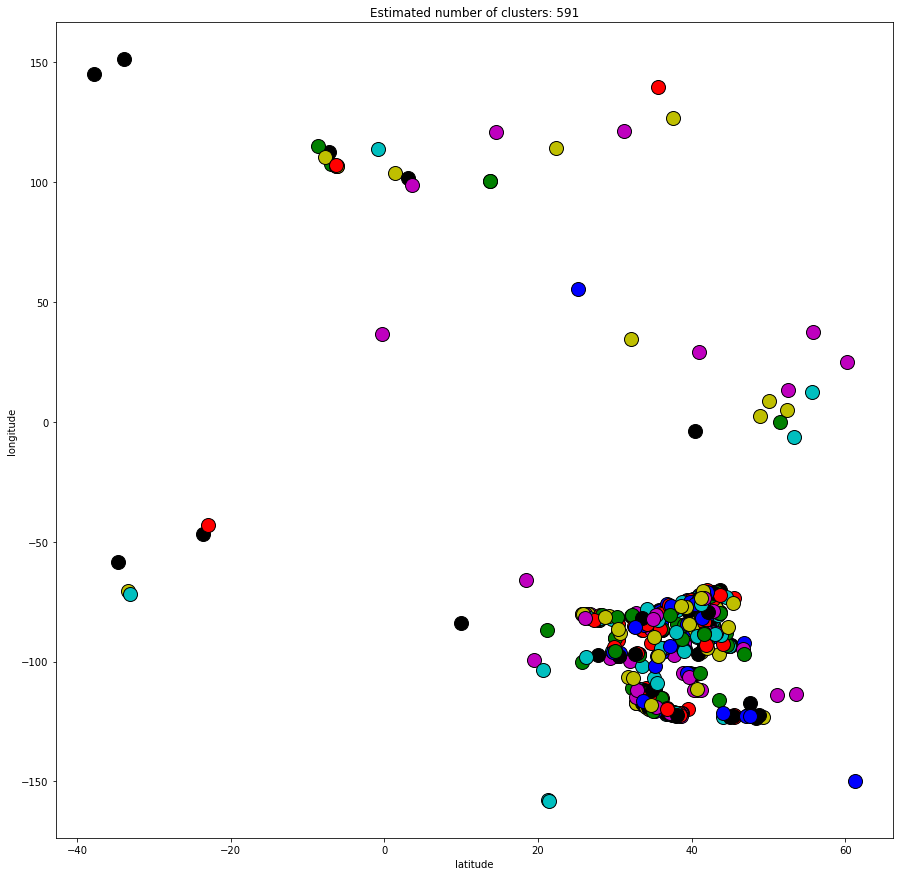

In [67]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import cycle
import random
import colorsys


def rgb2hex(rgb_arr):
    r,g,b = rgb_arr
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

def randcolor():
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r,g,b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]# r,g,b
    return (r,g,b,0.5)

colors = []
for i in range(n_clusters_):
    colors.append(randcolor())


plt.figure(figsize=(15,15))
plt.clf()
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    
for k, col in zip(range(n_clusters_), colors):
    if not k in big_clusters:
        continue
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=14)

    
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Estimated number of clusters: %d' % len(big_clusters) )


In [68]:
big_cluster_centers = []
for k in big_clusters.keys():
    big_cluster_centers.append(cluster_centers[k])
    

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:
<pre>
38.8951118,-77.0363658

33.800745,-84.41052

45.5234515,-122.6762071
</pre>


**Ответ:** Карта с центрами кластеров  
https://www.mapcustomizer.com/map/clusterize%20foursquare%20data

__________

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

<pre>
33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)
</pre>

In [69]:
offices_coords = [[33.751277, -118.188740],
                 [25.867736, -80.324116],
                 [51.503016, -0.075479],
                 [52.378894, 4.885084],
                 [39.366487, 117.036146],
                 [-33.868457, 151.205134]]

In [70]:
from scipy.spatial import distance

dist = []
for o in range(len(offices_coords)):
    for c in range(len(big_cluster_centers)):
        dist.append([distance.euclidean(offices_coords[o], big_cluster_centers[c]),  o, c])
        
sorted_dist = sorted(dist, key=lambda d: d[0])
result = sorted_dist[:20]

print(result)
for _, _, cluster_num in result:
    print(cluster_num, big_cluster_centers[cluster_num])

[[0.007830129410992547, 5, 138], [0.009356450016086563, 3, 269], [0.02267112557001763, 1, 354], [0.05005823818936693, 2, 117], [0.07071099439245516, 0, 18], [0.13409449749343014, 1, 164], [0.16742068363604146, 1, 139], [0.18887421167135915, 1, 111], [0.19571716048723214, 0, 183], [0.21152163380810302, 0, 92], [0.2222229854324734, 0, 123], [0.2712959761581327, 1, 247], [0.29498029120723007, 0, 277], [0.302202595855432, 1, 134], [0.30541040629862787, 0, 105], [0.31455330052350644, 0, 11], [0.33973666448517237, 0, 15], [0.3408471794788464, 1, 133], [0.3783992466010198, 0, 51], [0.3866679063696121, 0, 16]]
138 [-33.860634 151.2048  ]
269 [52.37296    4.8923173]
354 [ 25.845676 -80.318886]
117 [51.50291    -0.12553713]
18 [  33.809864 -118.14915 ]
164 [ 25.785921 -80.21787 ]
139 [ 25.70532  -80.283485]
111 [ 26.010141 -80.20004 ]
183 [  33.888313 -118.049   ]
92 [  33.87307 -118.36168]
123 [  33.972565 -118.16837 ]
247 [ 26.13884 -80.33433]
277 [  33.98394 -118.00741]
134 [ 26.12078  -80.15

_______________________

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Примечание**: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.

**Ответ: [-33.860634 151.2048] (возле офиса в Сиднее)**